<a href="https://colab.research.google.com/github/soesantanu/soesantanu.github.io/blob/main/Fused_Lasso_(m%2Cn)%3D(1000%2C2000).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import division
import numpy as np
import numpy.linalg as LA
from time import time
from itertools import count
from numpy.linalg import norm as LA_norm
import matplotlib.pyplot as plt
import builtins
import seaborn as sns


# Define proximal operators
def prox_f(x, tau, la):
    """
    Proximal operator of g(x) = lambda1 * ||x||_1.
    """
    return np.sign(x) * np.maximum(np.abs(x) - tau * la, 0)



def prox_g_conj(v: np.ndarray, la: float, tau: float) -> np.ndarray:
    """
    Proximal operator of τ·g*, where g(x) = λ||x||₁ and thus g*(y) = I_{||y||∞ ≤ λ}.
    Since g* is an indicator, prox_{τ g*}(v) is just the projection onto the ℓ∞-ball of radius λ.

    Parameters
    ----------
    v : np.ndarray
        Input vector.
    lam : float
        Radius λ of the ℓ∞-ball.
    tau : float
        Step size τ (unused, as prox is independent of τ for indicator functions).

    Returns
    -------
    np.ndarray
        The projected vector onto {y : ||y||∞ ≤ λ}, i.e., elementwise clipped to [−λ, λ].
    """
    return np.clip(v, -la, la)

def dh(x):
    return A.T.dot(A.dot(x)-b)

def J(x,y, min_val):
    t = A.dot(x)-b
    return np.abs(0.5* t.dot(t) + la* LA.norm(x,1) + la1* LA.norm((D.dot(x)),1) - min_val)


def pd_adaptive_Golden(J, prox_f,prox_g_conj, K, norm_K, x0, y0, tau, theta, beta,la,la1, tau_max, min_val, rho_val, phi, numb_iter=100):
    begin = time()

    x, y, z = x0, y0, x0
    values = [J(x0, y0, min_val)]
    tau_prev = tau
    theta_prev = theta
    tt = [0]
    tau_values = []
    sigma_values = []

    for i in range(numb_iter):

        z = x - (1 / phi) * (x - z)
        x1 = prox_f(z - tau_prev * K.T.dot(y) - tau_prev * dh(x), tau_prev, la)
        Kx1 = K.dot(x1)
        Kx = K.dot(x)
        x_norm = LA.norm(x - x1)**2
        dhx_norm = LA.norm(dh(x)-dh(x1))**2
        if dhx_norm != 0:
            L_bar_prev = (dhx_norm / x_norm)
            L_current1 = (phi * theta_prev ) / (9*tau_prev)
            L_n = L_current1 /((L_bar_prev + phi * beta * norm_K**2)) # Here norm_K is norm of D
            tau_n = builtins.min(rho_val * tau_prev, L_n, tau_max)
        else:
            tau_n = builtins.min(rho_val * tau_prev, tau_max)

        sigma_n = beta * tau_n
        y1 = prox_g_conj(y + sigma_n * Kx1, la1, sigma_n)
        print(f"Iteration {i}: J_gap = {J(x1, y1, min_val)}, tau_n = {tau_n}, x_norm = {LA.norm(x-x1)}, dhx_norm = {dhx_norm}")
        theta_n = phi * (tau_n / tau_prev)
        tau_prev = tau_n
        theta_prev = theta_n
        values.append(J(x1, y1, min_val))
        x, y = x1, y1
        tau_values.append(tau_n)  # Store tau_n value
        sigma_values.append(sigma_n)  # Store sigma_n value
        tt.append(time() - begin)
        err = values[-1]
        end = time()
        if err <= 1e-16:
            print ("Iter:", i+1)
            print ("----- Adaptive Golden-Ratio PDA -----")
            print ("Time execution:", round(end - begin,2))
            break
    if err > 1e-16:
      print ("Adaptive Golden-Ratio PDA does not terminate after", round(end - begin,2), "seconds")
    return [values, x, y, tt, sigma_values, tau_values]


def pd_Golden_Partial_adaptive(J, prox_f, prox_g_conj, K, x0, y0, mu, mu1,la,la1, beta, phi,tau, min_val, numb_iter=100):
    begin = time()
    x, y, z = x0, y0, x0
    values = [J(x0, y0, min_val)]
    tt = [0]
    tau_prev = tau
    tau_values = []
    sigma_values = []


    for i in range(numb_iter):

        z = x - (1 / phi) * (x - z)
        x1 = prox_f(z - tau_prev * K.T.dot(y) - tau_prev * dh(x), tau_prev, la)
        x_norm = LA.norm(x - x1)
        Kx_norm = LA.norm(K.dot(x) - K.dot(x1))
        dhx_norm = LA.norm(dh(x)-dh(x1))

        if Kx_norm != 0 and dhx_norm != 0:
            tau_n = builtins.min(tau_prev, (mu / np.sqrt(beta)) * (x_norm / Kx_norm), mu1 * (x_norm / dhx_norm)) # mu should be greater than 2*mu1
        elif Kx_norm != 0 and dhx_norm == 0:
            tau_n = min(tau_prev, (mu / np.sqrt(beta)) * (x_norm / Kx_norm))
        elif Kx_norm == 0 and dhx_norm != 0:
            tau_n = min(tau_prev, mu1 * (x_norm / dhx_norm))
        else:
            tau_n = tau_prev

        sigma_n = beta * tau_n
        y1 = prox_g_conj(y + sigma_n * K.dot(x1), la1, sigma_n)
        print(f"Iteration {i}: J_gap = {J(x1, y1, min_val)}, tau_n = {tau_n}, x_norm = {LA.norm(x-x1)}, Kx_norm = {Kx_norm}")
        values.append(J(x1, y1, min_val))
        tau_values.append(tau_n)  # Store tau_n value
        sigma_values.append(sigma_n)  # Store sigma_n value
        x, y, tau_prev = x1, y1, tau_n

        tt.append(time() - begin)
        err = values[-1]
        end = time()
        if err <= 1e-16:
            print ("Iter:", i+1)
            print ("----- Golden-Ratio PDA with partial adaptive step size-----")
            print ("Time execution:", round(end - begin,2))
            break
    if err > 1e-16:
      print ("Golden-Ratio PDA with partial adaptive step size does not terminate after", round(end - begin,2), "seconds")

    return [values, x, y, tt, sigma_values, tau_values]

def pd_Golden(J, prox_f, prox_g_conj, K,  x0, y0, sigma, tau, min_val, phi, numb_iter=100):
    """
    Golden-Ratio Primal-dual algorithm for the problem min_x
    max_y [<Kx,y> + g(x) - f*(y)]
    J denotes some function which we compute in every iteration to
    study perfomance. It may be energy, primal-dual gap, etc.
    """
    begin = time()

    x, y, z = x0, y0, x0
    values = [J(x0, y0, min_val)]
    tau_values = []
    sigma_values = []
    tt = [0]

    for i in range(numb_iter):
        z = x-(1/phi)*(x - z)
        x = prox_f(z - tau * K.T.dot(y) - tau * dh(x), tau, la)

        y = prox_g_conj(y + sigma * K.dot(x), la1, sigma)

        values.append(J(x, y, min_val))
        tau_values.append(tau)
        sigma_values.append(sigma)
        print(f"Iteration {i}: J_gap = {J(x, y, min_val)}, tau = {tau}, phi = {phi}")
        tt.append(time() - begin)
        err = values[-1]
        end = time()
        if err <= 1e-16:
            print ("Iter:", i+1)
            print ("----- Golden-Ratio Primal-dual method -----")
            print ("Time execution:", round(end - begin,2))
            break
    if err > 1e-16:
      print ("Golden-Ratio Primal-dual method does not terminate after", round(end - begin,2), "seconds")
    return [values, x, y,tt, sigma_values, tau_values]

def pd(J, prox_f, prox_g_conj, K,  x0, y0, sigma, tau, min_val, numb_iter=100):
    """
    Primal-dual algorithm of Pock and Chambolle for the problem min_x
    max_y [<Kx,y> + g(x) - f*(y)]
    J denotes some function which we compute in every iteration to
    study perfomance. It may be energy, primal-dual gap, etc.
    """
    begin = time()
    theta = 1.0
    x, y, z = x0, y0, x0
    values = [J(x0, y0, min_val)]
    tt = [0]
    tau_values = []
    sigma_values = []

    for i in range(numb_iter):
        x1 = prox_f(x - tau * K.T.dot(y)- tau * dh(x), tau, la)
        z = x1 + theta * (x1 - x)
        y = prox_g_conj(y + sigma * K.dot(z), la1, sigma)
        print(f"Iteration {i}: J_gap = {J(x, y, min_val)}, tau = {tau}, sigma = {sigma}, theta = {theta}")
        x = x1
        values.append(J(x, y, min_val))
        tau_values.append(tau)
        sigma_values.append(sigma)
        tt.append(time() - begin)
        err = values[-1]
        end = time()
        if err <= 1e-16:
            print ("Iter:", i+1)
            print ("----- Primal-dual method -----")
            print ("Time execution:", round(end - begin,2))
            break
    if err > 1e-16:
      print ("Primal-dual method does not terminate after", round(end - begin,2), "seconds")

    return [values, x, y, tt, sigma_values, tau_values]

# Define the algorithms
def VI_adaptive_Golden(J, prox_f, prox_g_conj, K, x0, y0, tau, min_val, theta, rho, tau_max, phi,numb_iter=100):
    begin = time()
    x, y = x0, y0
    x1, y1 = x0, y0
    z_x, z_y = x0, y0
    values = [J(x0, y0, min_val)]
    infeas = []
    max_inf = []
    L_n = None
    tau_prev = tau
    theta_prev = theta
    tt = [0]

    for i in range(numb_iter):
        z0 = np.concatenate((x, y))
        z1 = np.concatenate((x1, y1))
        Fz_0 = np.concatenate((K.T.dot(y) +  dh(x), -K.dot(x)))
        Fz_1 = np.concatenate((K.T.dot(y1) + dh(x1), -K.dot(x1)))
        z_norm = LA.norm(z0 - z1)
        Fz_norm = LA.norm(Fz_0 - Fz_1)
        if Fz_norm != 0:
            L_n = (phi * theta_prev / (4 * tau_prev)) * ((z_norm / Fz_norm) ** 2)
            tau_n = builtins.min(rho * tau_prev, L_n, tau_max)
        else:
            tau_n = builtins.min(rho * tau_prev, tau_max)
        z_x = x1 - (1 / phi) * (x1 - z_x)
        z_y = y1 - (1 / phi) * (y1 - z_y)

        x2 = prox_f(z_x - tau_n * K.T.dot(y1) - tau_n * dh(x), tau_n, la)
        y2 = prox_g_conj(z_y + tau_n * K.dot(x1), la1, tau_n)
        theta_n = phi * (tau_n / tau_prev)
        tau_prev = tau_n
        theta_prev = theta_n
        values.append(J(x2, y2, min_val))
        print(f"Iteration {i}: J_gap = {J(x2, y2, min_val)}, tau_n = {tau_n}, z_norm = {z_norm}, F_z_norm = {Fz_norm}, L_n = {L_n}")
        x, y = x1, y1
        x1, y1 = x2, y2

        tt.append(time() - begin)
        err = values[-1]
        end = time()
        if err <= 1e-16:
            print ("Iter:", i+1)
            print ("----- Adaptive Golden-Ratio Algorithm for VI -----")
            print ("Time execution:", round(end - begin,2))
            break

    if err > 1e-16:
     print ("Adaptive Golden-Ratio Algorithm for VI does not terminate after", round(end - begin,2), "seconds")
    return [values, x, y, tt]

In [2]:
n = 2000  #Change to 1000 for the second data set
m = 1000  #Chnage to 500 for the second data set
#n = 10
#m = 2
# s = 10
# la = 0.01
# la1 = 0.003
gen = 50
np.random.seed(gen)
A = np.random.normal(0,0.01, (m,n))
np.random.seed(gen)
w = np.random.uniform(0,1, n)
# w[s:] = 0
# np.random.seed(gen)
# w = np.random.permutation(w)

np.random.seed(gen)
nu = np.random.normal(0, 0.01, m)
b = A.dot(w) + nu
######################
D1 = np.eye(n-1, n)  # k=0 is the default for np.eye
D2 = np.eye(n-1, n, k=1)  # Use k=1 for the offset
D = D2 - D1
print(D)
# np.linalg.det(D)
L = np.sqrt(np.max(LA.eigh(D.dot(D.T))[0]))
print(L)
def lipschitz_constant(A):
    """
    Compute the Lipschitz constant of the gradient of h(x) = 1/2 ||Ax - b||^2.

    Parameters:
    A (numpy.ndarray): m x n real matrix

    Returns:
    float: Lipschitz constant
    """
    # Compute the singular values of A
    singular_values = np.linalg.svd(A, compute_uv=False)
    # The Lipschitz constant is the square of the largest singular value
    return max(singular_values)**2
L1 = lipschitz_constant(A)
print(L1)

tau1 = 2 /( 5*L1)
tau3 = 3 /( 5*L1)
sigma1 = (10 * L1) / (9*(L**2))
sigma2 = (3.50*L1) / (3*(L**2))
sigma3 = 2.0 * L1 / L**2

# Starting points
x0 = np.zeros(n)
y0 = np.zeros(n-1)

la = .001
la1 = .03
phi = 1.50
rho_val = 1./phi + 1./phi **2
beta = .01
beta2 = .001
tau = .001
tau_2 = 10
theta = 1
mu = 0.79
mu1 = .26
phi2 = 1.70
phi3 = 1.7 #
phi4 = (np.sqrt(5)+1)/2
tau_max = 1000000

[[-1.  1.  0. ...  0.  0.  0.]
 [ 0. -1.  1. ...  0.  0.  0.]
 [ 0.  0. -1. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  1.  0.  0.]
 [ 0.  0.  0. ... -1.  1.  0.]
 [ 0.  0.  0. ...  0. -1.  1.]]
1.999999383149757
0.5816092433146872


In [4]:
N = 15000
tau1 = 10
c_ = 0
ans4 = pd_Golden_Partial_adaptive(J, prox_f, prox_g_conj, D, x0, y0, mu, mu1, la, la1, beta, phi3, tau_2, c_, numb_iter=N)
ans2 = pd_adaptive_Golden(J, prox_f,prox_g_conj, D, L, x0, y0, tau_2, theta, beta,la,la1, tau_max, c_, rho_val, phi, numb_iter=N)
ans3 = pd_Golden(J, prox_f, prox_g_conj, D,  x0, y0, 5*sigma1, .2*tau3, c_, phi4, numb_iter=N)
ans5 = pd(J, prox_f, prox_g_conj, D,  x0, y0, 25*sigma1, .04*tau3, c_, numb_iter=N)
ans7 = VI_adaptive_Golden(J, prox_f, prox_g_conj, D, x0, y0, tau_2, c_, theta, rho_val, tau_max, phi,numb_iter=N)


Streaming output truncated to the last 5000 lines.
Iteration 10001: J_gap = 5.485387399030362, tau_n = 0.6155263982307615, z_norm = 5.643827566804106e-13, F_z_norm = 4.808994923847981e-13, L_n = 1.5539235917540137
Iteration 10002: J_gap = 5.48538739903036, tau_n = 0.6839182202564017, z_norm = 6.251512508775988e-13, F_z_norm = 5.317448858664608e-13, L_n = 1.4034498536881714
Iteration 10003: J_gap = 5.485387399030363, tau_n = 0.7599091336182241, z_norm = 6.922949419972715e-13, F_z_norm = 5.882182534267963e-13, L_n = 1.2658468524591207
Iteration 10004: J_gap = 5.485387399030365, tau_n = 0.8443434817980268, z_norm = 7.667952422274078e-13, F_z_norm = 6.518465215237069e-13, L_n = 1.1381158386471433
Iteration 10005: J_gap = 5.485387399030365, tau_n = 0.9381594242200297, z_norm = 8.492453949031224e-13, F_z_norm = 7.234378162600404e-13, L_n = 1.0200579609888794
Iteration 10006: J_gap = 5.485387399030389, tau_n = 0.9083469018191002, z_norm = 9.410197127109906e-13, F_z_norm = 8.058877188370403e-1

In [5]:
min_values = []  # Create a list to store minimum values from each list
for v in [ans2[0], ans3[0], ans4[0], ans5[0]]:
    # Get the minimum value of the list 'v' and append it to min_values
    min_values.append(builtins.min(v))

# Now, find the overall minimum from the collected minimum values
min_val = min(min_values)

print(f'{min_val:.30f}')  # Print with 30 decimal places

5.485387399030253519072175549809


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

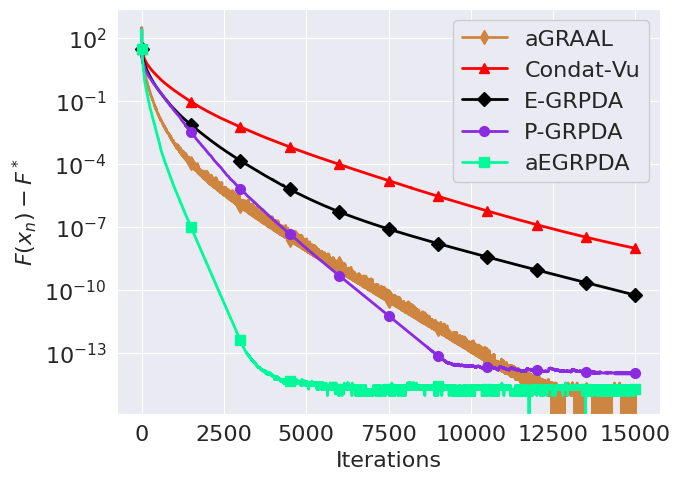

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files

#1) Set seaborn style
sns.set_style('darkgrid')
plt.rcParams['legend.facecolor'] = plt.rcParams['axes.facecolor']

#2) Update Matplotlib parameters
plt.rcParams.update({
    'font.size':        13,
    'figure.figsize':   (7, 5),
    'legend.fontsize':  16,
    'lines.linewidth':  2,
    'axes.labelsize':   16,
    'xtick.labelsize':  16,
    'ytick.labelsize':  16,
    'xtick.major.pad':  4,
    'ytick.major.pad':  4,
})

#4) Define your plots: (iterations, error, label, marker, color)
plots = [
    (np.arange(len(ans7[0])), np.array(ans7[0]) - min_val, 'aGRAAL',  'd', '#CD853F'),
    (np.arange(len(ans5[0])), np.array(ans5[0]) - min_val, 'Condat‑Vu','^','red'),
    (np.arange(len(ans3[0])), np.array(ans3[0]) - min_val, 'E‑GRPDA', 'D','black'),
    (np.arange(len(ans4[0])), np.array(ans4[0]) - min_val, 'P‑GRPDA', 'o','#8A2BE2'),
    (np.arange(len(ans2[0])), np.array(ans2[0]) - min_val, 'aEGRPDA', 's','#00FA9A'),
]

#5) Plot each with markers
plt.figure()
for x, y, lbl, mk, col in plots:
    me = max(1, len(x)//10)
    plt.plot(x, y,
             color=col,
             marker=mk,
             markersize=7,
             markevery=me,
             label=lbl)

plt.yscale('log')
plt.xlabel('Iterations')
plt.ylabel(r'$F(x_n) - F^*$')

# ——— 6) Semi‐transparent legend & grid ———
plt.legend(framealpha=1.0, loc='upper right')
plt.grid(True)
plt.tight_layout()

# ——— 7) Save & download ———
plt.savefig('error_graph.eps', dpi=700)
files.download('error_graph.eps')

plt.show()


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

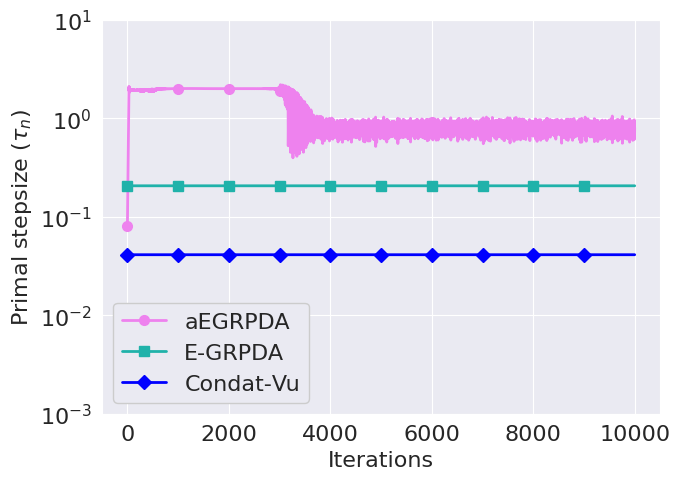

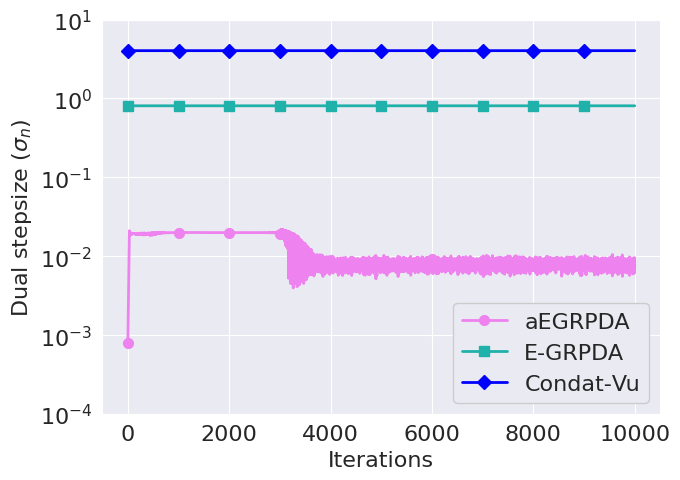

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ——— 1) Style ———
sns.set_style('darkgrid')
plt.rcParams['legend.facecolor'] = plt.rcParams['axes.facecolor']
plt.rcParams.update({
    'font.size':        13,
    'figure.figsize':   (7, 5),
    'legend.fontsize':  16,
    'lines.linewidth':  2,
    'axes.labelsize':   16,
    'xtick.labelsize':  16,
    'ytick.labelsize':  16,
    'xtick.major.pad':  4,
    'ytick.major.pad':  4,
})

# aEGRPDA (adaptive Golden-Ratio PDA)
_, _, _, tt_adapt, sigma_adapt, tau_adapt = ans2

# E‑GRPDA (Golden‑Ratio PDA)
_, _, _, tt_golden, sigma_golden, tau_golden = ans3

# Chambolle-Pock)
_, _, _, tt_pd, sigma_pd, tau_pd = ans5

#####
K = 10000
tau_adapt = np.array(tau_adapt)[:K]
tau_golden= np.array(tau_golden)[:K]
tau_pd    = np.array(tau_pd)[:K]
sigma_adapt = np.array(sigma_adapt)[:K]
sigma_golden= np.array(sigma_golden)[:K]
sigma_pd    = np.array(sigma_pd)[:K]

#4) Plot tau_n for all three ———
plt.figure()
for tau_vals, lbl, color, mk in [
    (tau_adapt,    'aEGRPDA',       '#EE82EE', 'o'),
    (tau_golden,   'E‑GRPDA',       '#20B2AA', 's'),
    (tau_pd,       'Condat‑Vu','blue',    'D'),
]:
    it = np.arange(len(tau_vals))
    me = max(1, len(it)//10)
    plt.plot(it, tau_vals,
             label=lbl,
             color=color,
             marker=mk,
             markersize=7,
             markevery=me)

plt.yscale('log')
plt.xlabel('Iterations')
plt.ylabel(r'Primal stepsize ($\tau_n$)')
plt.ylim([1e-3, 1e1])
plt.legend(framealpha=1.0, loc='best')
plt.tight_layout()
plt.savefig('primal.eps', dpi=700)
files.download('primal.eps')
plt.show()

#5) Plot sigma_n for all three ———
plt.figure()
for sigma_vals, lbl, color, mk in [
    (sigma_adapt,    'aEGRPDA',       '#EE82EE', 'o'),
    (sigma_golden,   'E‑GRPDA',       '#20B2AA', 's'),
    (sigma_pd,       'Condat‑Vu','blue',    'D'),
]:
    it = np.arange(len(sigma_vals))
    me = max(1, len(it)//10)
    plt.plot(it, sigma_vals,
             label=lbl,
             color=color,
             marker=mk,
             markersize=7,
             markevery=me)

plt.yscale('log')
plt.xlabel('Iterations')
plt.ylabel(r'Dual stepsize ($\sigma_n$)')
plt.ylim([1e-4, 1e1])
plt.legend(framealpha=1.0, loc='best')
plt.tight_layout()
# plt.savefig('dual_steps.eps', dpi=700)
# files.download('dual_steps.eps')
plt.show()
